# 0. Imports 

In [125]:
import matplotlib
import optuna

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn import tree
from xgboost import XGBClassifier
from optuna import Trial

from imblearn import over_sampling as oversamp
from imblearn import under_sampling as undersamp

# 1. Loading Data 

In [57]:
df1_client_train = pd.read_csv('dataset/client_train.csv', low_memory=False)
df1_invoice_train = pd.read_csv('dataset/invoice_train.csv', low_memory=False)

# 2. Data Description 

In [58]:
df2_client_train = df1_client_train.copy()
df2_invoice_train = df1_invoice_train.copy()

## 2.0 Data Dimensions 

In [59]:
print(f'df2_client_train (lines = {df2_client_train.shape[0]}, cols = {df2_client_train.shape[1]})')
print(f'df2_invoice_train (lines = {df2_invoice_train.shape[0]}, cols = {df2_invoice_train.shape[1]})')

df2_client_train (lines = 135493, cols = 6)
df2_invoice_train (lines = 4476749, cols = 16)


## 2.1 Data Types 

In [60]:
print('-----------------------------------')
print('df2_client_train')
print('-----------------------------------')
print(df2_client_train.dtypes)
print('-----------------------------------')
print('df2_invoice_train')
print('-----------------------------------')
print(df2_invoice_train.dtypes)

-----------------------------------
df2_client_train
-----------------------------------
disrict            int64
client_id         object
client_catg        int64
region             int64
creation_date     object
target           float64
dtype: object
-----------------------------------
df2_invoice_train
-----------------------------------
client_id               object
invoice_date            object
tarif_type               int64
counter_number           int64
counter_statue          object
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type            object
dtype: object


## 2.2 Checking Na 

In [61]:
print('-----------------------------------')
print('df2_client_train')
print('-----------------------------------')
print(df2_client_train.isna().sum())
print('-----------------------------------')
print('df2_invoice_train')
print('-----------------------------------')
print(df2_invoice_train.isna().sum())


-----------------------------------
df2_client_train
-----------------------------------
disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64
-----------------------------------
df2_invoice_train
-----------------------------------
client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64


## 2.3 Data Overview 

### 2.3.1 Clients 

In [62]:
df2_client_train.columns.tolist()

['disrict', 'client_id', 'client_catg', 'region', 'creation_date', 'target']

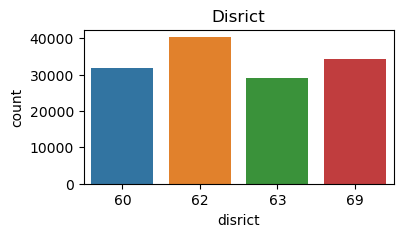

In [63]:
plt.figure(figsize=(4,2));
sns.countplot(data=df2_client_train, x='disrict');
plt.title('Disrict'); # provavelmente distrito

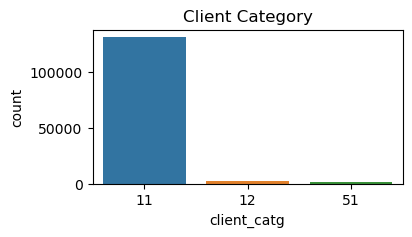

In [64]:
plt.figure(figsize=(4,2));
sns.countplot(data=df2_client_train, x='client_catg');
plt.title('Client Category');

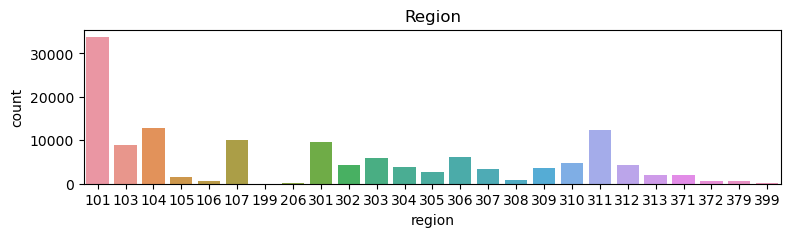

In [65]:
plt.figure(figsize=(9,2));
sns.countplot(data=df2_client_train, x='region');
plt.title('Region');

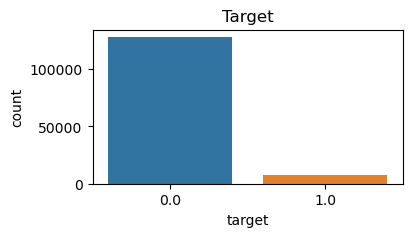

In [66]:
plt.figure(figsize=(4,2))
sns.countplot(data=df2_client_train, x='target');
plt.title('Target');

In [67]:
df2_client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


### 2.3.2 Invoices 

In [68]:
df2_invoice_train.columns.tolist()

['client_id',
 'invoice_date',
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'counter_coefficient',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type']

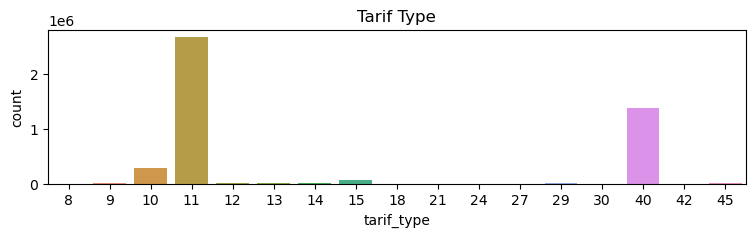

In [69]:
plt.figure(figsize=(9,2))
sns.countplot(data=df2_invoice_train, x='tarif_type');
plt.title('Tarif Type');

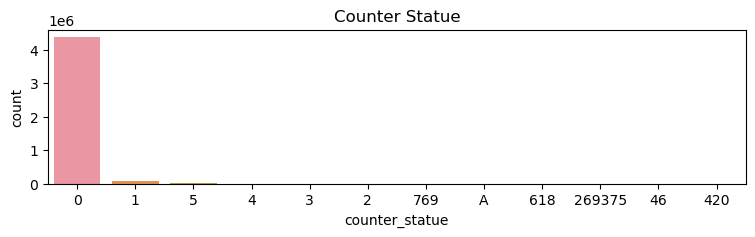

In [70]:
plt.figure(figsize=(9,2))
sns.countplot(data=df2_invoice_train, x='counter_statue');
plt.title('Counter Statue');

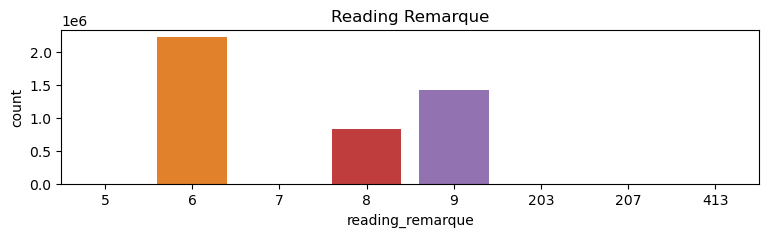

In [71]:
plt.figure(figsize=(9,2));
sns.countplot(data=df2_invoice_train, x='reading_remarque');
plt.title('Reading Remarque');

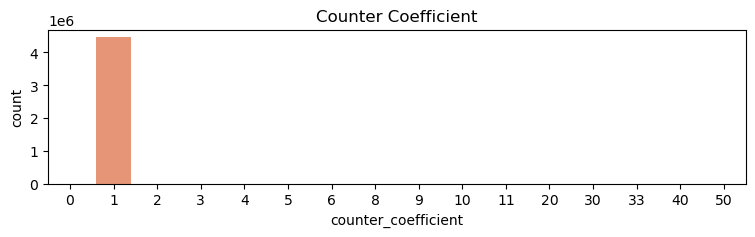

In [72]:
plt.figure(figsize=(9,2));
sns.countplot(data=df2_invoice_train, x='counter_coefficient');
plt.title('Counter Coefficient');

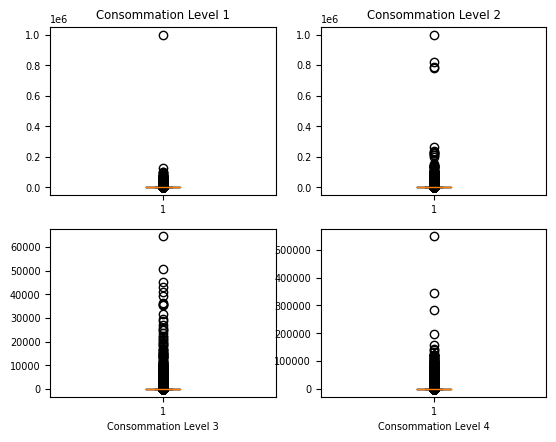

In [73]:
font = {'weight': 'normal', 'size': 7}

matplotlib.rc('font', **font)

plt.subplot(2,2,1);
plt.boxplot(df2_invoice_train.consommation_level_1);
plt.title('Consommation Level 1');

plt.subplot(2,2,2);
plt.boxplot(df2_invoice_train.consommation_level_2);
plt.title('Consommation Level 2');

plt.subplot(2,2,3);
plt.boxplot(df2_invoice_train.consommation_level_3);
plt.xlabel('Consommation Level 3');

plt.subplot(2,2,4);
plt.boxplot(df2_invoice_train.consommation_level_4);
plt.xlabel('Consommation Level 4');

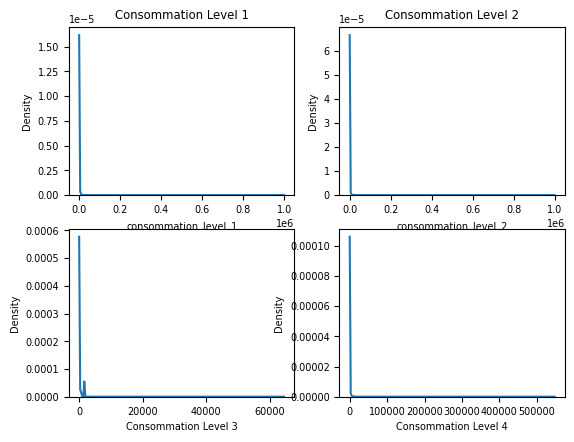

In [74]:
matplotlib.rc('font', **font)

plt.subplot(2,2,1);
sns.kdeplot(x=df2_invoice_train.consommation_level_1);
plt.title('Consommation Level 1');

plt.subplot(2,2,2);
sns.kdeplot(x=df2_invoice_train.consommation_level_2);
plt.title('Consommation Level 2');

plt.subplot(2,2,3);
sns.kdeplot(x=df2_invoice_train.consommation_level_3);
plt.xlabel('Consommation Level 3');

plt.subplot(2,2,4);
sns.kdeplot(x=df2_invoice_train.consommation_level_4);
plt.xlabel('Consommation Level 4');

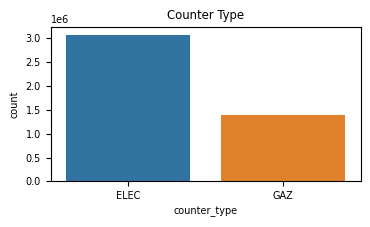

In [75]:
plt.figure(figsize=(4,2));
sns.countplot(data=df2_invoice_train, x='counter_type');
plt.title('Counter Type');

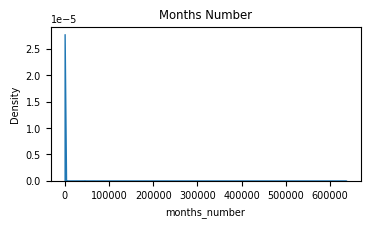

In [76]:
plt.figure(figsize=(4,2));
sns.kdeplot(data=df2_invoice_train, x='months_number', shade=True);
plt.title('Months Number');

In [77]:
df2_invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


## 2.4 Conclusions 

- Alterar o tipo de dado dos atributos 'creation_date' do dataframe de clientes, e os atributos 'reading_remarque',  'invoice_date' e 'counter_type' do dataframe invoices;
- Não existem dados ausentes;
- Como esperado, o target para fraudes é bastante subrepresentado (desbalanceamento);
- 'counter_statue', 'counter_remarquee' e e 'counter_coefficient' precisam ser tratados, pois tem ums distribuição de valores inadequada;
- Existem muito mais invoices de eletricidade que gás no dataset;
- 'consommation_level_x' tem distribuição com bastante outliers, indicando uma variabilidade alta nos consumos;


# 3. Feature Engineering

In [78]:
df3_client_train = df2_client_train.copy()
df3_invoice_train = df2_invoice_train.copy()

## 3.1 Changing Types

### 3.1.1 Client 

In [79]:
df3_client_train.dtypes

disrict            int64
client_id         object
client_catg        int64
region             int64
creation_date     object
target           float64
dtype: object

In [80]:
df3_client_train['creation_date'] = pd.to_datetime(df3_client_train.creation_date, infer_datetime_format=True)
#df3_client_train['disrict'] = df3_client_train.disrict.astype('category')
#df3_client_train['client_catg'] = df3_client_train.client_catg.astype('category')
#df3_client_train['region'] = df3_client_train.region.astype('category')
df3_client_train['target'] = df3_client_train.target.astype('int64')

In [81]:
df3_client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,1994-12-31,0
1,69,train_Client_1,11,107,2002-05-29,0
2,62,train_Client_10,11,301,1986-03-13,0
3,69,train_Client_100,11,105,1996-07-11,0
4,62,train_Client_1000,11,303,2014-10-14,0


### 3.1.2 Invoice 

In [82]:
df3_invoice_train.dtypes

client_id               object
invoice_date            object
tarif_type               int64
counter_number           int64
counter_statue          object
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type            object
dtype: object

In [83]:
df3_invoice_train['invoice_date'] = pd.to_datetime(df3_invoice_train.invoice_date, infer_datetime_format=True)
df3_invoice_train['tarif_type'] = df3_invoice_train.tarif_type.astype('category')
df3_invoice_train['counter_statue'] = df3_invoice_train.counter_statue.astype('category')
df3_invoice_train['reading_remarque'] = df3_invoice_train.reading_remarque.astype('category')
df3_invoice_train['counter_type'] = df3_invoice_train.counter_type.astype('category')
df3_invoice_train['counter_type'] = df3_invoice_train.counter_type.map({'ELEC': 1, 'GAZ': 0})

In [84]:
df3_invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,1
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,1
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,1
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,1
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,1


## 3.2 Features Creation and Manipulation

### 3.2.1 Client 

In [85]:
# ano, mes e idade
df3_client_train['year_creation'] = df3_client_train.creation_date.dt.year
df3_client_train['month_creation'] = df3_client_train.creation_date.dt.month
df3_client_train['age'] = (2020 - df3_client_train.year_creation) * 12 - df3_client_train.month_creation

In [86]:
df3_client_train.insert(len(df3_client_train.columns)-1, 'target', df3_client_train.pop('target'))
df3_client_train.head()

,disrict,client_id,client_catg,region,creation_date,year_creation,month_creation,age,target
0,60,train_Client_0,11,101,1994-12-31,1994,12,300,0
1,69,train_Client_1,11,107,2002-05-29,2002,5,211,0
2,62,train_Client_10,11,301,1986-03-13,1986,3,405,0
3,69,train_Client_100,11,105,1996-07-11,1996,7,281,0
4,62,train_Client_1000,11,303,2014-10-14,2014,10,62,0


### 3.2.2 Invoice 

In [87]:
# consumo, ano, mes e intervelo entre leituras
df3_invoice_train['delta_index'] = df3_invoice_train.new_index - df3_invoice_train.old_index
df3_invoice_train['invoice_year'] = df3_invoice_train['invoice_date'].dt.year
df3_invoice_train['invoice_month'] = df3_invoice_train['invoice_date'].dt.month
df3_invoice_train['delta_dates'] = df3_invoice_train.sort_values(['client_id', 'invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)

In [88]:
# atributos estatisticos com base na serie historica
features_to_agg = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'months_number', 'delta_index', 'delta_dates']
stats_features = df3_invoice_train.groupby('client_id')[features_to_agg].agg(['mean','std','min','max'])
stats_features.columns = ['_'.join(col).strip() for col in stats_features.columns.values]

In [89]:
# traduzindo os itens de counter_statue para algo mais simples
df3_invoice_train['counter_statue'].unique().tolist()

['0', '1', '5', '4', '3', '2', '769', 'A', '618', '269375', '46', '420']

In [90]:
df3_invoice_train['counter_statue'] = df3_invoice_train.counter_statue.map({'0': 0, '1': 1, '5': 5, '4': 4, '3': 3, '2': 2, '769': 6, 'A': 7, '618': 8, '269375': 9, '46': 10, '420': 11})

## 3.5 Merging DataFrames

In [91]:
df3 = pd.merge(df3_client_train, stats_features, on='client_id', how='left')
df3.insert(len(df3.columns)-1, 'target', df3.pop('target'))
df3.head()

,disrict,client_id,client_catg,region,creation_date,year_creation,month_creation,age,consommation_level_1_mean,consommation_level_1_std,...,months_number_max,delta_index_mean,delta_index_std,delta_index_min,delta_index_max,delta_dates_mean,delta_dates_std,delta_dates_min,delta_dates_max,target
0,60,train_Client_0,11,101,1994-12-31,1994,12,300,352.400000,310.343472,...,12,362.971429,341.553930,38,1386,144.147059,87.601070,40.0,508.0,0
1,69,train_Client_1,11,107,2002-05-29,2002,5,211,557.540541,197.935960,...,8,557.540541,197.935960,190,1207,136.472222,92.492312,4.0,372.0,0
2,62,train_Client_10,11,301,1986-03-13,1986,3,405,798.611111,513.841374,...,12,836.500000,646.808386,188,3082,289.470588,250.701794,20.0,738.0,0
3,69,train_Client_100,11,105,1996-07-11,1996,7,281,1.200000,3.607011,...,6,1.200000,3.607011,0,15,140.210526,95.569974,4.0,442.0,0
4,62,train_Client_1000,11,303,2014-10-14,2014,10,62,663.714286,224.831365,...,4,922.642857,633.485669,124,2382,121.923077,80.057752,4.0,301.0,0


# 4. Exploratory Data Analysis 

In [92]:
df4 = df3.copy()

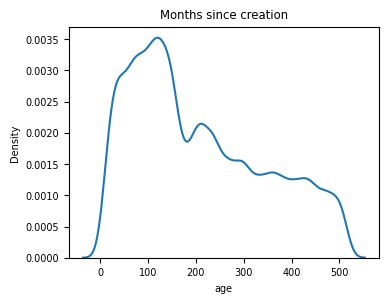

In [93]:
plt.figure(figsize=(4,3));
sns.kdeplot(data=df4, x='age');
plt.title('Months since creation');

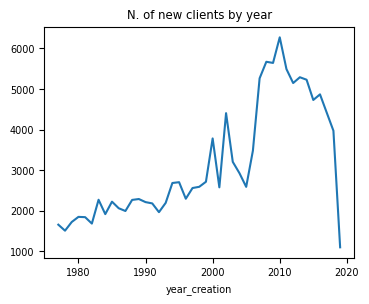

In [94]:
plt.figure(figsize=(4,3));
df4.groupby(by='year_creation').size().plot();
plt.title('N. of new clients by year');

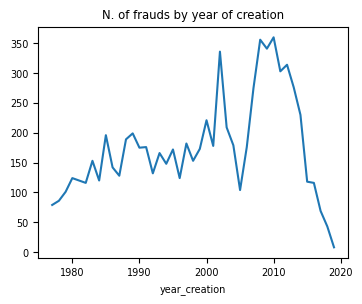

In [95]:
plt.figure(figsize=(4,3));
df4.groupby(by='year_creation').sum()['target'].plot();
plt.title('N. of frauds by year of creation');

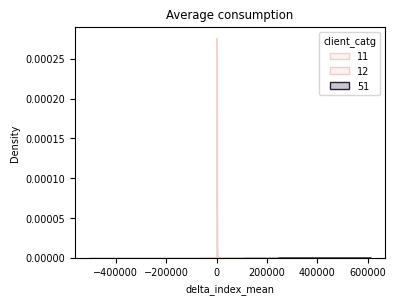

In [96]:
plt.figure(figsize=(4,3));
sns.kdeplot(data=df4, x='delta_index_mean', shade=True, hue='client_catg');
plt.title('Average consumption');

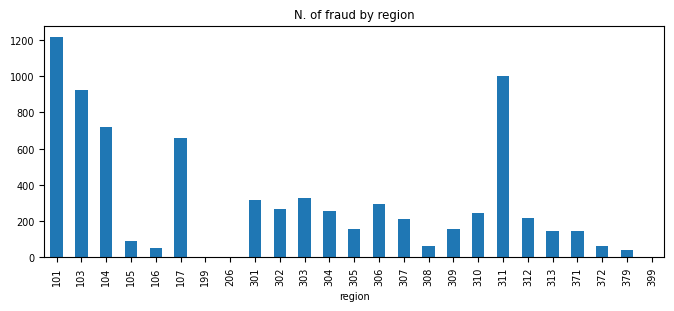

In [97]:
plt.figure(figsize=(8,3));
df4.groupby('region')['target'].sum().plot(kind='bar');
plt.title('N. of fraud by region');

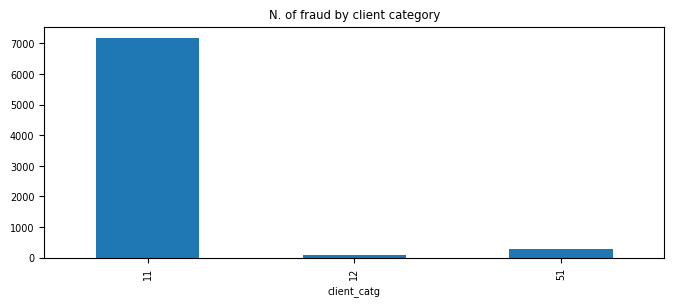

In [98]:
plt.figure(figsize=(8,3));
df4.groupby('client_catg')['target'].sum().plot(kind='bar');
plt.title('N. of fraud by client category');

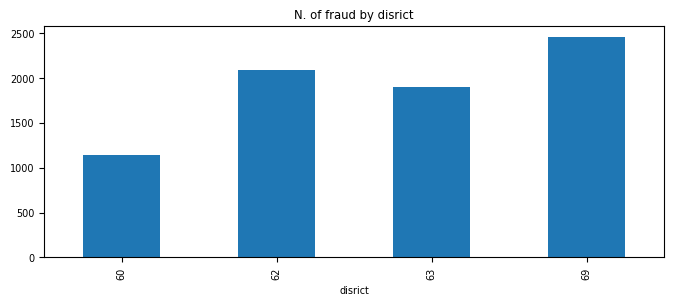

In [99]:
plt.figure(figsize=(8,3));
df4.groupby('disrict')['target'].sum().plot(kind='bar');
plt.title('N. of fraud by disrict');

## 4.1 Conclusions 

- A maioria dos clientes tem ~8 anos de relacionamento com a empresa;
- O número de clientes cresceu a uma taxa constante entre os anos 1980 e 1990, mas em 2005 houve um crescimento massivo;
- O número de fraudes registradas com relação ao ano de início do relacionamento com o cliente segue um padrão próximo ao do número de novos clientes da empresa, sendo os cliente novos entre 2005-2010 um grupo de fraudadores bastante intenso.
- A região mais fraudulenta é a 101;
- A categoria de cliente mais fraudulento é o 11;
- O distrito mais fraudulento é o 69.

# 5. Data Preparation 

In [100]:
df5 = df4.copy()

In [101]:
df5 = df5.drop(['client_id', 'creation_date'], axis=1).dropna()

In [102]:
X, y = df5.drop('target', axis=1), df5[['target']]

## 5.1 Split Data 

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [104]:
undersampling = undersamp.RandomUnderSampler(sampling_strategy='all', random_state=42)
X_train, y_train = undersampling.fit_resample(X_train, y_train)

## 5.1 Oversampling 

# 6. Machine Learning Modeling 

## 6.1 Decision Tree 

In [105]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [106]:
print(f'Accuracy score = {accuracy_score(y_test, y_pred_dt)}')
print(f'F1-Score = {f1_score(y_test, y_pred_dt)}')
print(f'ROC-AUC Score = {roc_auc_score(y_test, y_pred_dt)}')

Accuracy score = 0.6054579534263113
F1-Score = 0.15037285352671548
ROC-AUC Score = 0.5948111229256926


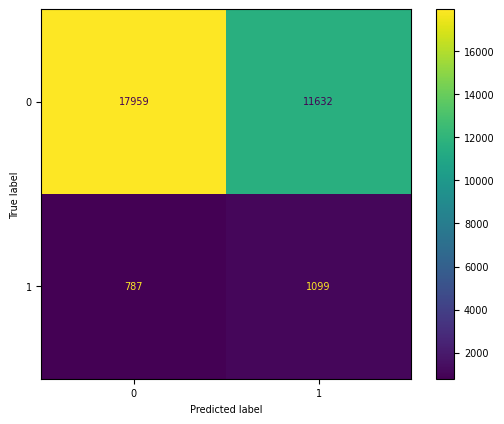

In [107]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt);

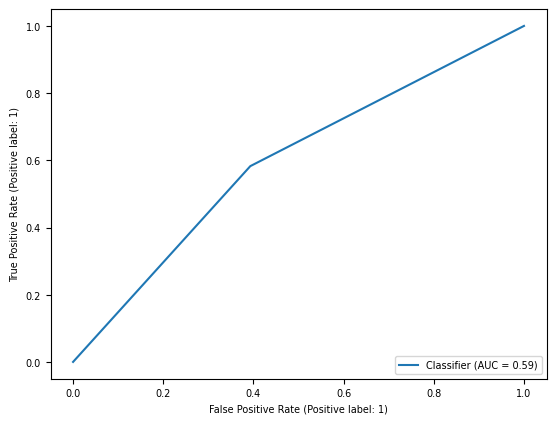

In [108]:
RocCurveDisplay.from_predictions(y_test, y_pred_dt);

## 7.2 LightGBM 

In [109]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train.values.ravel())
y_pred_lgbm = lgbm.predict(X_test)

In [110]:
print(f'Accuracy score = {accuracy_score(y_test, y_pred_lgbm)}')
print(f'F1-Score = {f1_score(y_test, y_pred_lgbm)}')
print(f'ROC-AUC Score = {roc_auc_score(y_test, y_pred_lgbm)}')

Accuracy score = 0.6724274867363472
F1-Score = 0.20568523226253754
ROC-AUC Score = 0.6890086399905276


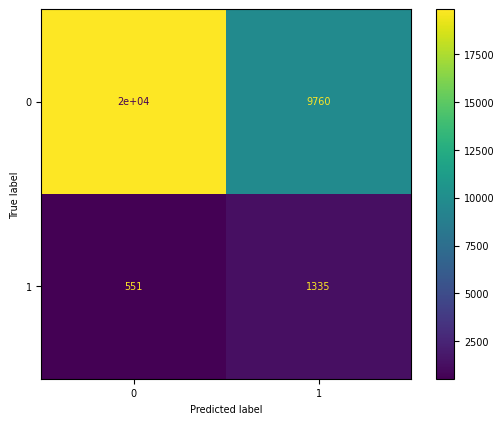

In [111]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm);

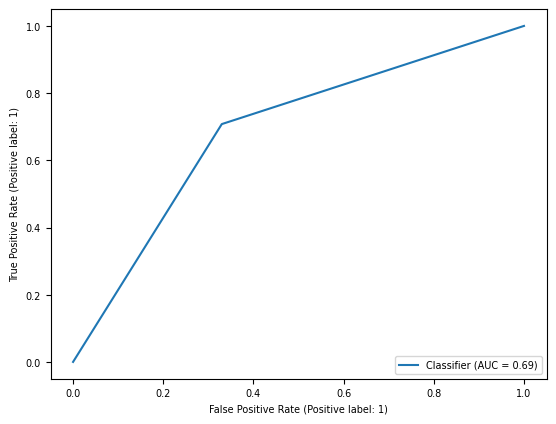

In [112]:
RocCurveDisplay.from_predictions(y_test, y_pred_lgbm);

## 7.3 XGBoost 

In [113]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [114]:
print(f'Accuracy score = {accuracy_score(y_test, y_pred_xgb)}')
print(f'F1-Score = {f1_score(y_test, y_pred_xgb)}')
print(f'ROC-AUC Score = {roc_auc_score(y_test, y_pred_xgb)}')

Accuracy score = 0.6603551799726785
F1-Score = 0.20079240487403752
ROC-AUC Score = 0.6845734833177939


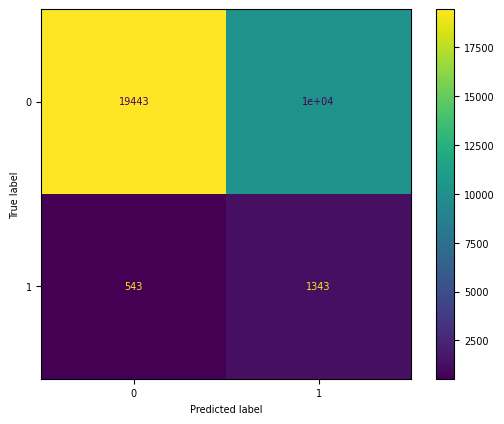

In [115]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb);

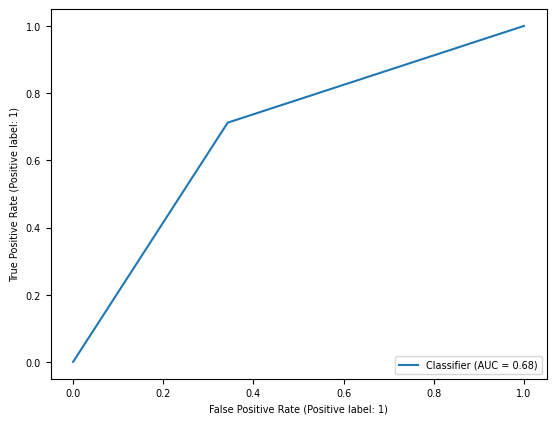

In [116]:
RocCurveDisplay.from_predictions(y_test, y_pred_xgb);

## 7.4 Summary Results 

In [117]:
results = {'Model': ['Decision Tree', 'LighGBM', 'XGBoost'],
           'Accuracy': [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_lgbm), accuracy_score(y_test, y_pred_xgb) ],
           'F1-Score': [f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_lgbm), f1_score(y_test, y_pred_xgb)],
           'ROC-AUC Score': [roc_auc_score(y_test, y_pred_dt), roc_auc_score(y_test, y_pred_lgbm), roc_auc_score(y_test, y_pred_xgb)]}

pd.DataFrame(results).sort_values('ROC-AUC Score', ascending=False)

,Model,Accuracy,F1-Score,ROC-AUC Score
1,LighGBM,0.672427,0.205685,0.689009
2,XGBoost,0.660355,0.200792,0.684573
0,Decision Tree,0.605458,0.150373,0.594811


- Podemos ver que o melhor modelo foi o LightGBM nas três métricas avaliadas;
- Na próxima seção será feito o fine tuning do modelo;

# 8. Fine Tuning and Cross Validation

In [227]:
cv = StratifiedKFold(n_splits=5)
random_search = RandomizedSearchCV(lgb.LGBMClassifier(random_state=42), 
                             {
                                 'n_estimators': np.arange(1,1000, 50), 
                                 'num_leaves': 2**np.arange(1, 10, 1),
                                 'max_depth': 2**np.arange(1, 8, 1),
                                 'learning_rate': np.arange(0.001, 0.3, 0.001),
                                 'min_split_gain': np.arange(0.001, 0.50, 0.005),
                                 'feature_fraction': np.arange(0.01, 1.0, 0.1),
                                 'bagging_freq': np.arange(1, 10, 1),                                 
                             }, scoring=['f1', 'accuracy', 'recall','roc_auc'], refit='roc_auc',  n_iter=100, cv=cv, n_jobs=-1)

results = random_search.fit(X_train, y_train.values.ravel())

In [234]:
metrics = {
    'F1-Score': results.cv_results_['mean_test_f1'],
    'Accuracy': results.cv_results_['mean_test_accuracy'],
    'Recall':   results.cv_results_['mean_test_recall'],
    'AUC-ROC':  results.cv_results_['mean_test_roc_auc'],
}

pd.DataFrame(metrics).sort_values(by='AUC-ROC', ascending=False).head(1)

,F1-Score,Accuracy,Recall,AUC-ROC
88,0.695631,0.683966,0.72231,0.755403


In [229]:
pd.DataFrame(metrics).describe()

,F1-Score,Accuracy,Recall,AUC-ROC
count,100.000000,100.000000,100.000000,100.000000
mean,0.681115,0.670790,0.703907,0.735730
std,0.015349,0.015877,0.025010,0.021210
min,0.614146,0.600233,0.601939,0.638946
25%,0.672095,0.664282,0.687674,0.729996
50%,0.685506,0.675139,0.705191,0.741565
75%,0.692436,0.681314,0.719327,0.748977
max,0.698523,0.686999,0.822735,0.755403


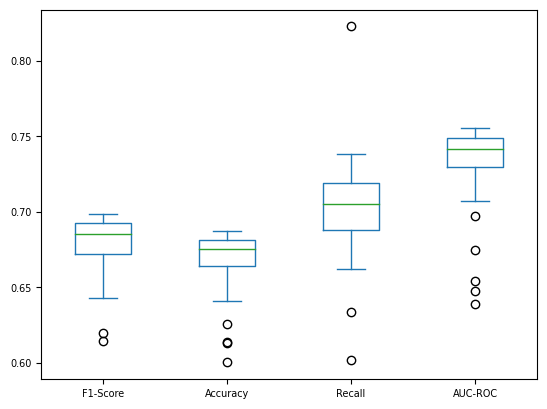

In [230]:
pd.DataFrame(metrics).plot(kind='box');

# 9. Best Model 

In [231]:
results.best_params_

{'num_leaves': 32,
 'n_estimators': 351,
 'min_split_gain': 0.481,
 'max_depth': 4,
 'learning_rate': 0.039,
 'feature_fraction': 0.51,
 'bagging_freq': 9}

In [232]:
results.best_score_

0.7554031269232535

# 10. Conclusions 

- O melhor modelo foi uma versão do LightGBM;
- O melhor modelo teve F1-score = 0.7, Accuracy = 0.68, Recall = 0.72 e AUC-ROC = 0.76;
- Sob a perspectiva destas métricas, a precisão das idas a campo para inspeções será consideravelmente assertiva, levando a uma maior recuperação de receita ao mitigar estas fraudes.